Tarea 1 - Ramiro Sanes (368397) y Joaquín Guerra (307854)

# Tarea 1 - Taller de Deep Learning

**Fecha de entrega: 19/10/2025**  
**Puntaje máximo: 15**

## Introducción

El objetivo de esta tarea es evaluar su conocimiento sobre Deep Learning aplicado a un caso de uso real. En particular, vamos a evaluar la performance de sus modelos en una tarea de clasificación de escenas.

**Dataset**

El dataset a ser utilizado es **Imagenette**, una versión simplificada de ImageNet que consiste de 10 clases. Pueden encontrar más información y descargarlo en el siguiente [link](https://pytorch.org/vision/main/generated/torchvision.datasets.Imagenette.html).

**Tarea**

Tienen total libertad sobre cómo implementar y resolver el problema así como las técnicas y herramientas que quieran usar. Recomendamos usar Colab por simplicidad, pero pueden implementarlo en sus máquinas si así lo prefieren. La única limitante es que esperamos que la entrega sea en formato .ipynb (Jupyter Notebook) **con las celdas ya ejecutadas**.

**Restricciones**

- No se permite utilizar models pre-entrenados (cada modelo debe ser implementado desde cero)
- Se requiere que utilicen al menos 2 técnicas de **regularización** (Dropout, BatchNorm, Data Augmentation, etc.)
- Se requiere realizar un **análisis de los datos**, que incluya el balanceo de clases y tomar decisiones en base al análisis realizado.
- Las decisiones tomadas sobre el preprocesamiento de las imágenes (transforms, augmentation, etc.) deben ser resultado de la exploración del dataset y estar propiamente justificadas (una sección de exploración en el notebook con comentarios es suficiente).

**Reporte**

En particular, les pedimos que reporten: accuracy, precision, recall y f1.
También se espera poder observar la evolución del modelo (en los datos de train y validación) a medida que se entrena (logs, gráficas, etc).

**Evidencia de Experimentos**

Además, deben presentar evidencia de correr experimentos usando [Weights & Biases (wandb)](https://wandb.ai/). Esto incluye:
- Registros detallados de los experimentos.
- Gráficas y logs de entrenamiento.
- Comparaciones entre diferentes configuraciones de modelos.

In [1]:
!pip install torchvision

In [3]:
import torchvision.datasets as datasets
from pathlib import Path
from collections import Counter
import torch
from torchvision.transforms import v2 as T
from torch.utils.data import DataLoader, random_split
import utils
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import wandb

In [ ]:
DATA_DIR = Path("data")

imagenette_dataset = datasets.Imagenette(
    DATA_DIR, download=False
)


In [ ]:
name_classes = imagenette_dataset.classes
nclasses = len(name_classes)

print(f"Clases: {name_classes}")

Clases: [('tench', 'Tinca tinca'), ('English springer', 'English springer spaniel'), ('cassette player',), ('chain saw', 'chainsaw'), ('church', 'church building'), ('French horn', 'horn'), ('garbage truck', 'dustcart'), ('gas pump', 'gasoline pump', 'petrol pump', 'island dispenser'), ('golf ball',), ('parachute', 'chute')]


In [ ]:
# Contamos la cantidad de imágenes por clase
labels = [imagenette_dataset.classes[target] for _, target in imagenette_dataset]
conteo = Counter(labels)


In [ ]:
print(f'Cantidad de imágenes en el dataset: {len(labels)}')

Cantidad de imágenes en el dataset: 9469


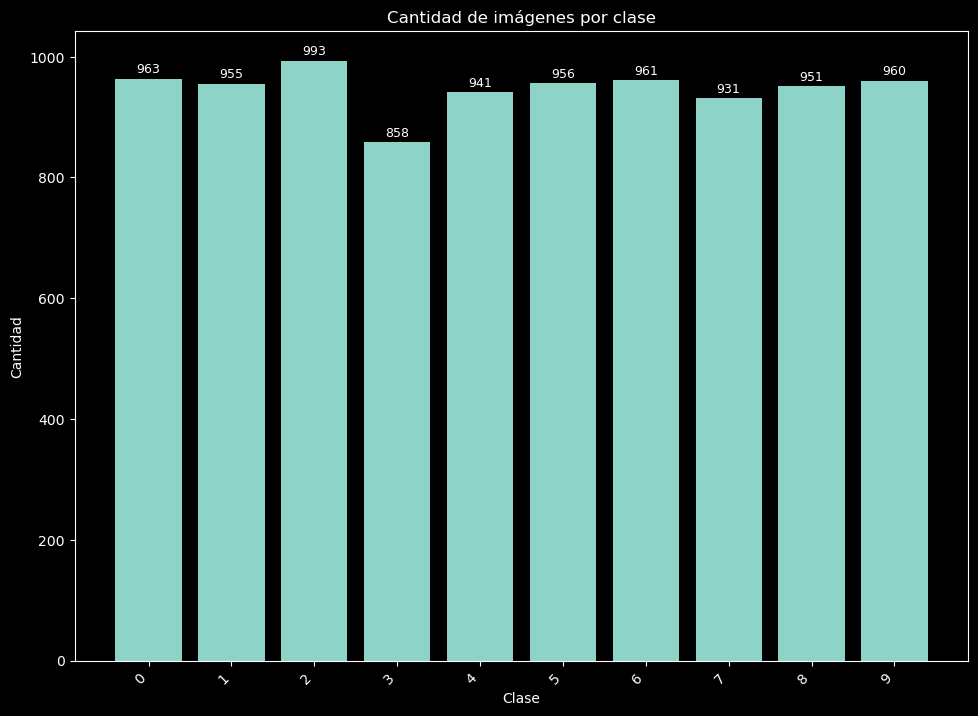

In [ ]:
plt.figure(figsize=(10, 10))
plt.bar([", ".join(cls) for cls in conteo.keys()], conteo.values())
plt.xticks(rotation=45, ha='right')
plt.title("Cantidad de imágenes por clase")
plt.ylabel("Cantidad")
plt.xlabel("Clase")
plt.tight_layout()
for i, (k, v) in enumerate(zip(conteo.keys(), conteo.values())):
    plt.text(i, v + 5, str(v), ha='center', va='bottom', fontsize=9)
plt.xticks(ticks=range(len(conteo)), labels=range(len(conteo)), rotation=45, ha='right')
plt.show()

Si bien observamos que el dataset no contiene la misma cantidad exacta de imágenes por clase podríamos decir que el mismo esta balanceado.
La clase con más datos contiene el 10.5% del total mientras que la que tiene menos datos representa el 9.1%

In [ ]:
sizes = [imagenette_dataset[i][0].size for i in range(len(imagenette_dataset))]
conteo_sizes = Counter(sizes)

In [ ]:
print(f"Cantidad de tamaños únicos: {len(conteo_sizes.keys())}")

Cantidad de tamaños únicos: 2296


In [ ]:
conteo_sizes.most_common()

[((500, 375), 2174),
 ((500, 333), 818),
 ((375, 500), 717),
 ((333, 500), 309),
 ((500, 334), 207),
 ((640, 480), 126),
 ((500, 332), 91),
 ((500, 500), 88),
 ((400, 300), 78),
 ((500, 335), 75),
 ((334, 500), 67),
 ((500, 400), 53),
 ((500, 374), 46),
 ((332, 500), 45),
 ((200, 150), 44),
 ((500, 376), 42),
 ((335, 500), 38),
 ((600, 450), 36),
 ((500, 357), 34),
 ((500, 377), 33),
 ((240, 180), 31),
 ((1600, 1200), 31),
 ((400, 500), 30),
 ((250, 250), 27),
 ((1024, 768), 27),
 ((800, 600), 26),
 ((90, 90), 26),
 ((320, 240), 25),
 ((376, 500), 23),
 ((100, 100), 23),
 ((500, 281), 22),
 ((500, 338), 20),
 ((357, 500), 20),
 ((280, 280), 20),
 ((500, 337), 19),
 ((400, 400), 19),
 ((480, 360), 18),
 ((300, 225), 17),
 ((500, 331), 17),
 ((300, 300), 17),
 ((500, 340), 16),
 ((500, 341), 16),
 ((160, 160), 16),
 ((200, 200), 16),
 ((773, 1162), 16),
 ((1162, 773), 16),
 ((500, 348), 15),
 ((338, 500), 15),
 ((377, 500), 15),
 ((500, 350), 14),
 ((500, 381), 14),
 ((500, 395), 14),
 (

Aplicamos los transforms ToImage() para pasar las imágenes a tensores y Resize() para que todas las imágenes tengan el mismo tamaño (224,224)

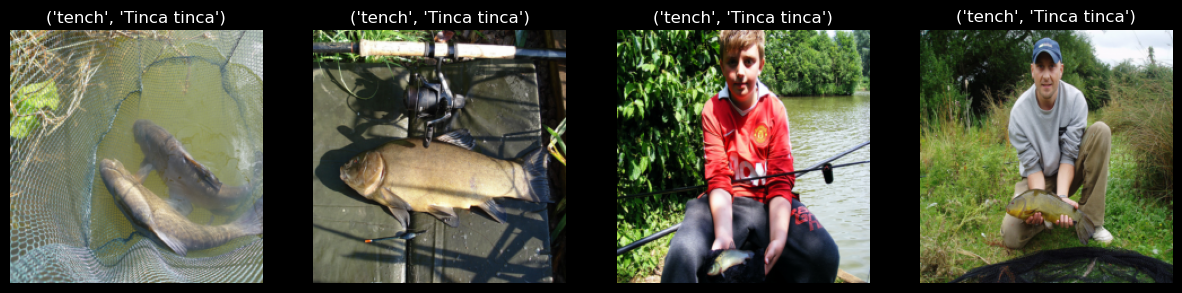

In [ ]:
transforms = T.Compose([
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True),
    T.Resize((224, 224))

])

imagenette_dataset_train = datasets.Imagenette(
    DATA_DIR, download=False,split = 'train', transform=transforms
)

imagenette_dataset_val = datasets.Imagenette(
    DATA_DIR, download=False,split = 'val', transform=transforms
)

utils.show_tensor_images([imagenette_dataset_train[i][0] for i in range(4)], titles=[imagenette_dataset_train.classes[imagenette_dataset_train[i][1]] for i in range(4)])


In [ ]:
sizes_final = [imagenette_dataset_train[i][0].size() for i in range(len(imagenette_dataset_train))]


In [ ]:
conteo_sizes_final = Counter(sizes_final)
conteo_sizes_final

Counter({torch.Size([3, 224, 224]): 9469})

In [ ]:
imagenette_dataset_train, imagenette_dataset_test = random_split(
    imagenette_dataset_train, [0.8, 0.2]
)

Entrenamiento

In [ ]:
import sys

# definimos el dispositivo que vamos a usar
DEVICE = "cpu"  # por defecto, usamos la CPU
if torch.cuda.is_available():
    DEVICE = "cuda"  # si hay GPU, usamos la GPU
elif torch.backends.mps.is_available():
    DEVICE = "mps"  # si no hay GPU, pero hay MPS, usamos MPS
elif torch.xpu.is_available():
    DEVICE = "xpu"  # si no hay GPU, pero hay XPU, usamos XPU

print(f"Usando {DEVICE}")

NUM_WORKERS = 0 # Win y MacOS pueden tener problemas con múltiples workers
if sys.platform == 'linux':
    NUM_WORKERS = 4  # numero de workers para cargar los datos (depende de cada caso)

print(f"Usando {NUM_WORKERS}")

Usando cuda
Usando 4


In [ ]:
BATCH_SIZE = 32  # tamaño del batch

Definimos la funcion get_dataloaders para crear los dataloaders de entrenamiento, validación y test

In [ ]:
def get_dataloaders(batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    train_loader = DataLoader(
        imagenette_dataset_train,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
    )

    val_loader = DataLoader(
        imagenette_dataset_val,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
    )

    test_loader = DataLoader(
        imagenette_dataset_test,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
    )

    return train_loader, val_loader, test_loader


train_loader, val_loader, test_loader = get_dataloaders()

## Red convolucional simple sin regularizar

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, input, n_classes):
        super().__init__()
        self.conv = nn.Sequential(
            #224*224
            nn.Conv2d(input[0], 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #112*112
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #56*56
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
            #28*28
            )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 28 * 28, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, n_classes),
        )
    def forward(self, x):
        x = self.conv(x)
        x = self.classifier(x)
        return x




Instanciamos el modelo

In [ ]:
# Instanciar el modelo
model = SimpleCNN(train_loader.dataset[0][0].shape, nclasses).to(DEVICE)
print(model)

SimpleCNN(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=50176, out_features=512, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU(inplace=True)
    (5): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [ ]:
# Funciones de entrenamiento/validación rápidas (para prueba)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
train_errors, val_errors = utils.train(model, optimizer=optimizer, criterion=criterion, do_early_stopping=False,train_loader=train_loader, val_loader=val_loader, device=DEVICE, epochs=10)

Epoch: 001 | Train Loss: 2.04050 | Val Loss: 2.03767
Epoch: 002 | Train Loss: 1.64765 | Val Loss: 1.52614
Epoch: 003 | Train Loss: 1.28177 | Val Loss: 1.43422
Epoch: 004 | Train Loss: 1.06449 | Val Loss: 1.22511
Epoch: 005 | Train Loss: 0.82793 | Val Loss: 1.18929
Epoch: 006 | Train Loss: 0.58849 | Val Loss: 1.29811
Epoch: 007 | Train Loss: 0.33424 | Val Loss: 1.53686
Epoch: 008 | Train Loss: 0.18880 | Val Loss: 1.66235
Epoch: 009 | Train Loss: 0.10243 | Val Loss: 1.91236
Epoch: 010 | Train Loss: 0.04454 | Val Loss: 2.36273


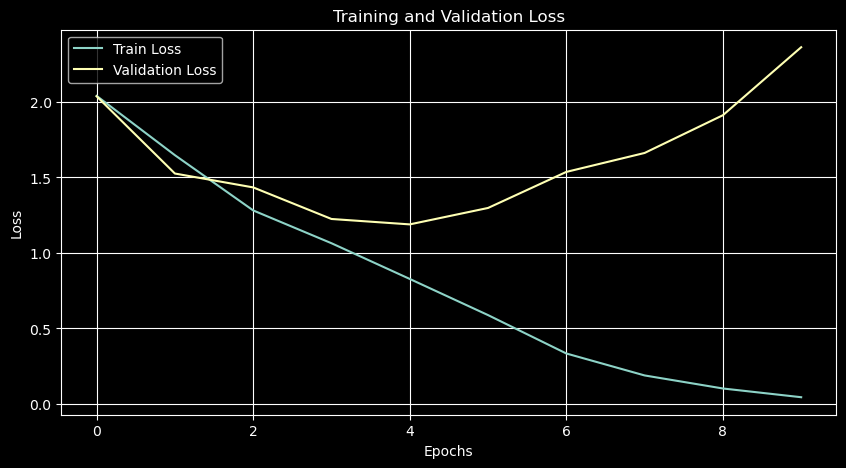

Accuracy: 0.5843

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.78      0.70      0.74       205
           1       0.58      0.67      0.62       177
           2       0.61      0.73      0.67       209
           3       0.36      0.37      0.37       172
           4       0.58      0.76      0.66       183
           5       0.64      0.58      0.61       191
           6       0.69      0.50      0.58       203
           7       0.37      0.52      0.43       172
           8       0.62      0.42      0.51       200
           9       0.71      0.57      0.64       181

    accuracy                           0.58      1893
   macro avg       0.60      0.58      0.58      1893
weighted avg       0.60      0.58      0.59      1893



In [ ]:
utils.plot_taining(train_errors, val_errors)
utils.model_calassification_report(model, test_loader, DEVICE, nclasses)

Tanto en el log que se imprime durante el entrenamiento como en el grafico, se observa claramente como a partir de la 5ta epoca, el modelo comienza a sobreajustar, por lo que creamos una nueva red utilizando las siguientes técnicas de regularización buscando evitar el sobreajuste.



*   **Dropout**: Colocamos una capa de dropout luego de cada activación de las capas convolucionales y también a la salida de las capas lineales del clasificador.

*   **Batch Normalization**: Colocamos capas BatchNorm2d luego de cada capa convolucional así como también luego de las capas lineales del clasificador.

* **Early Stopping**: Entrenamos el modelo con early stopping definiendo la paciencia en 10 epocas.



In [ ]:
class RegularizedCNN(nn.Module):
    def __init__(self, input, n_classes, dropout_rate=0.5):
        super().__init__()
        self.conv = nn.Sequential(
            # 224*224
            nn.Conv2d(input[0], 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),  # Batch Normalization
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),


            # 112*112
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.2),
            nn.MaxPool2d(kernel_size=2, stride=2),


            # 56*56
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.25),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # 28*28
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 28 * 28, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),

            nn.Linear(256, n_classes),
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.classifier(x)
        return x



In [ ]:
model_reg = RegularizedCNN(train_loader.dataset[0][0].shape, nclasses).to(DEVICE)
print(model_reg)

RegularizedCNN(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout2d(p=0.1, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): Dropout2d(p=0.2, inplace=False)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): Dropout2d(p=0.25, inplace=False)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  

In [ ]:
criterion_reg = nn.CrossEntropyLoss()
optimizer_reg = optim.Adam(model_reg.parameters(), lr=1e-3)

In [ ]:
train_errors_reg, val_errors_reg = utils.train(
    model_reg,
    optimizer=optimizer_reg,
    criterion=criterion_reg,
    do_early_stopping=True,
    patience=3,
    train_loader=train_loader,
    val_loader=val_loader,
    device=DEVICE,
    epochs=30
)

Epoch: 001 | Train Loss: 1.93427 | Val Loss: 1.75528
Epoch: 002 | Train Loss: 1.61324 | Val Loss: 1.38783
Epoch: 003 | Train Loss: 1.43698 | Val Loss: 1.27794
Epoch: 004 | Train Loss: 1.34489 | Val Loss: 1.23699
Epoch: 005 | Train Loss: 1.25577 | Val Loss: 1.11938
Epoch: 006 | Train Loss: 1.13320 | Val Loss: 1.10410
Epoch: 007 | Train Loss: 1.03641 | Val Loss: 1.11358
Epoch: 008 | Train Loss: 0.95253 | Val Loss: 1.10339
Epoch: 009 | Train Loss: 0.88182 | Val Loss: 1.13733
Epoch: 010 | Train Loss: 0.78784 | Val Loss: 1.13862
Epoch: 011 | Train Loss: 0.67912 | Val Loss: 1.17244
Detener entrenamiento en la época 10, la mejor pérdida fue 1.10339


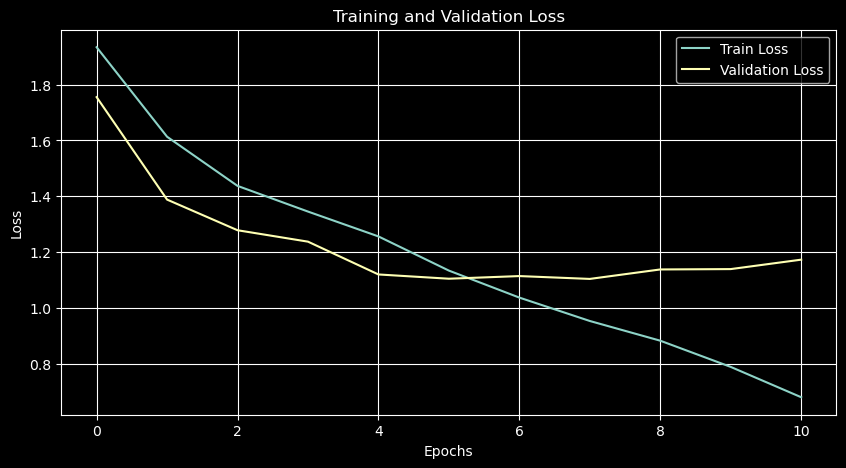

Accuracy: 0.6455

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.67      0.85      0.75       205
           1       0.59      0.59      0.59       177
           2       0.77      0.70      0.73       209
           3       0.47      0.40      0.43       172
           4       0.58      0.71      0.64       183
           5       0.75      0.59      0.66       191
           6       0.76      0.56      0.65       203
           7       0.50      0.64      0.56       172
           8       0.68      0.60      0.64       200
           9       0.71      0.79      0.75       181

    accuracy                           0.65      1893
   macro avg       0.65      0.64      0.64      1893
weighted avg       0.65      0.65      0.64      1893



In [ ]:
utils.plot_taining(train_errors_reg, val_errors_reg)
utils.model_calassification_report(model_reg, test_loader, DEVICE, nclasses)

## DenseNet

Creamos una DenseNet de la misma forma que lo hicimos en clase, con algunas pequeñas modificaciones debido a que las imágenes de entrada son bastante más grandes a las que usamos durante el curso.



*   Modificamos el kernel_size de la capa inicial a 7 (igual que está en el paper)
*   Agregamos pooling a la capa inicial para reducir la dimensión antes



In [ ]:
class DenseLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DenseLayer, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(True)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        y = self.bn(x)
        y = self.relu(y)
        y = self.conv(y)
        return torch.cat([x, y], 1)

In [ ]:
class DenseBlock(nn.Module):
    def __init__(self, num_layers, in_channels, growth_rate):
        super(DenseBlock, self).__init__()
        self.block = []
        for i in range(num_layers):
            self.block.append(DenseLayer(in_channels + i * growth_rate, growth_rate))
        self.denseBlock = nn.Sequential(*self.block)

    def forward(self, x):
        return self.denseBlock(x)

In [ ]:
class TransitionLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionLayer, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(True)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        return(self.pool(self.conv(self.relu(self.bn(x)))))

In [ ]:
class DenseNet(nn.Module):
    def __init__(self, num_layers = [6, 12, 24, 16], growth_rate=32, num_classes=10):
        super(DenseNet, self).__init__()
        self.growth_rate = growth_rate
        self.num_layers = num_layers
        self.num_blocks = len(num_layers)

        # Capa inicial: se encarga de extraer características iniciales
        current_channels = 3
        self.convI = nn.Conv2d(current_channels, 2 * growth_rate, kernel_size=7,stride=2,padding=3, bias=False)
        current_channels = 2*growth_rate
        self.bnI = nn.BatchNorm2d(current_channels)
        self.reluI = nn.ReLU(True)
        self.poolI = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        denseBlock = []
        # Bloques densos y capas de transición en nn.Sequential
        for i in range(self.num_blocks):
            current_layers = num_layers[i]
            denseBlock += [DenseBlock(current_layers, current_channels, growth_rate)]
            current_channels += current_layers * growth_rate
            if i != self.num_blocks - 1:
                denseBlock += [TransitionLayer(current_channels, current_channels // 2)]
                current_channels = current_channels // 2
        self.dense_blocks = nn.Sequential(*denseBlock)


        # Capa de clasificación
        self.avgPooling = nn.AdaptiveAvgPool2d((1,1))
        self.flatten = nn.Flatten(start_dim=1)
        self.classifier = nn.Linear(current_channels, num_classes)


    def forward(self, x):
        x = self.convI(x)
        x = self.bnI(x)
        x = self.reluI(x)
        x = self.poolI(x)
        x = self.dense_blocks(x)
        x = self.avgPooling(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x


DenseNet(
  (convI): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bnI): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (reluI): ReLU(inplace=True)
  (poolI): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (dense_blocks): Sequential(
    (0): DenseBlock(
      (denseBlock): Sequential(
        (0): DenseLayer(
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (1): DenseLayer(
          (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv): Conv2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (2): DenseLayer(
          (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_

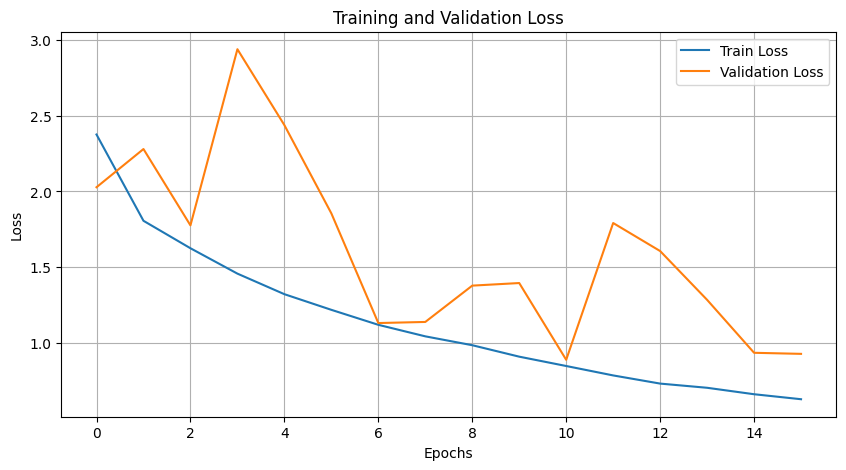

Accuracy: 0.7052

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.91      0.86      0.88       207
           1       0.84      0.65      0.73       198
           2       0.77      0.71      0.74       205
           3       0.33      0.79      0.46       149
           4       0.79      0.79      0.79       187
           5       0.52      0.74      0.61       186
           6       0.88      0.69      0.77       191
           7       0.91      0.51      0.65       217
           8       0.89      0.57      0.70       172
           9       0.88      0.78      0.82       181

    accuracy                           0.71      1893
   macro avg       0.77      0.71      0.72      1893
weighted avg       0.78      0.71      0.72      1893



In [ ]:
# Instanciar el modelo DenseNet
model_densenet = DenseNet(num_layers=[6, 12, 24, 16], growth_rate=32, num_classes=nclasses).to(DEVICE)

print(model_densenet)

# Definir el criterio y optimizador
criterion_densenet = nn.CrossEntropyLoss()
optimizer_densenet = optim.Adam(model_densenet.parameters(), lr=1e-3)
#optimizer_densenet = torch.optim.AdamW(model_densenet.parameters(), lr=3e-4, weight_decay=1e-4)

# Entrenar el modelo
train_errors_densenet, val_errors_densenet = utils.train(
    model_densenet,
    optimizer=optimizer_densenet,
    criterion=criterion_densenet,
    do_early_stopping=True,
    patience=5,
    train_loader=train_loader,
    val_loader=val_loader,
    device=DEVICE,
    epochs=30
)

# Visualizar resultados
utils.plot_taining(train_errors_densenet, val_errors_densenet)
utils.model_calassification_report(model_densenet, test_loader, DEVICE, nclasses)

Con la DenseNet obtuvimos mejores resultados, alcanzando un 70% de accuracy y 0.89 de Val Loss mínima

## Utilizamos Weight & Bias

Utilizamos la herramienta Weight & Bias para entrenar el modelo regularizado con distintos hiperparámetros observando su performance

In [6]:
WANDB_TEAM_NAME = "joacoguerrae-ort"
WANDB_PROJECT = "[wandb-labo1-guerra-sanes]"
wandb.login()

True

In [ ]:
class RegularizedCNN_Wandb(nn.Module):
    def __init__(self, input, n_classes, dropout_rate=0.5):
        super().__init__()
        self.conv = nn.Sequential(
            # 224*224
            nn.Conv2d(input[0], 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),  # Batch Normalization
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),


            # 112*112
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.2),
            nn.MaxPool2d(kernel_size=2, stride=2),


            # 56*56
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.25),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # 28*28
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 28 * 28, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),

            nn.Linear(256, n_classes),
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.classifier(x)
        return x

# Crear el modelo con regularización
modelo_regularizado_wandb = RegularizedCNN_Wandb(train_loader.dataset[0][0].shape, nclasses, dropout_rate=0.5).to(DEVICE)
print(modelo_regularizado_wandb)

# Optimizer con weight decay (L2 regularization)
optimizer_reg = optim.Adam(modelo_regularizado_wandb.parameters(), lr=1e-3, weight_decay=1e-4)

RegularizedCNN_Wandb(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout2d(p=0.1, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): Dropout2d(p=0.2, inplace=False)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): Dropout2d(p=0.25, inplace=False)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


Configuración del sweep:

In [ ]:
sweep_config = {
    "name": "sweep-imagenette-regularized",
    "method": "bayes",
    "metric": {"name": "val_loss", "goal": "minimize"},
    "parameters": {
        "learning_rate": {
            "distribution": "log_uniform_values",
            "min": 1e-5,
            "max": 1e-2
        },
        "optimizer": {
            "values": ["adam", "sgd"]
        },
        "batch_size": {
            "values": [32, 64, 128, 256]
        },
        "dropout_rate": {
            "distribution": "uniform",
            "min": 0.2,
            "max": 0.7
        },
        "weight_decay": {
            "distribution": "log_uniform_values",
            "min": 1e-6,
            "max": 1e-3
        },
        "momentum": {
            "distribution": "uniform",
            "min": 0.85,
            "max": 0.99
        },

    },
    "early_terminate": {
        "type": "hyperband",
        "min_iter": 5
    }
}


In [ ]:
def train_with_wandb(config=None):
    with wandb.init(config=config):
        # Obtener la configuración del sweep
        config = wandb.config

        # Crear dataloaders con el batch_size del sweep
        train_loader_sweep, val_loader_sweep, test_loader_sweep = get_dataloaders(
            batch_size=config.batch_size,
            num_workers=NUM_WORKERS
        )

        # Crear el modelo con los parámetros del sweep
        model = RegularizedCNN_Wandb(
            train_loader_sweep.dataset[0][0].shape,
            nclasses,
            dropout_rate=config.dropout_rate
        ).to(DEVICE)

        # Definir el optimizador según la configuración
        if config.optimizer == "adam":
            optimizer = optim.Adam(
                model.parameters(),
                lr=config.learning_rate,
                weight_decay=config.weight_decay
            )
        elif config.optimizer == "sgd":
            optimizer = optim.SGD(
                model.parameters(),
                lr=config.learning_rate,
                momentum=config.momentum,
                weight_decay=config.weight_decay
            )

        # Criterio de pérdida
        criterion = nn.CrossEntropyLoss()

        # Entrenar el modelo
        train_errors, val_errors = utils.train(
            model,
            optimizer=optimizer,
            criterion=criterion,
            do_early_stopping=True,
            train_loader=train_loader_sweep,
            val_loader=val_loader_sweep,
            device=DEVICE,
            epochs=30,
            patience=10
        )

        if val_errors:
            best_val = float(min(val_errors))
            wandb.run.summary["val_loss"] = best_val

        # Evaluamos el conjunto en test
        model.eval()
        test_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, targets in test_loader_sweep:
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

        test_accuracy = 100. * correct / total
        test_loss = test_loss / len(test_loader_sweep)

        # Log de métricas finales
        wandb.log({
            "test_accuracy": test_accuracy,
            "test_loss": test_loss
        })

        print(f"Test Accuracy: {test_accuracy:.2f}%")

In [ ]:
#Creamos el sweep
sweep_id = wandb.sweep(sweep_config, project=WANDB_PROJECT)

print(f"Sweep ID: {sweep_id}")

Create sweep with ID: f8289p22
Sweep URL: https://wandb.ai/joacoguerrae-ort/%5Bwandb-labo1-guerra-sanes%5D/sweeps/f8289p22
Sweep ID: f8289p22


In [ ]:
wandb.agent(sweep_id, function=train_with_wandb, count=20)

wandb: Agent Starting Run: wil5v2ur with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.5777815445429679
wandb: 	learning_rate: 0.00033982736515596824
wandb: 	momentum: 0.8904216819437548
wandb: 	optimizer: sgd
wandb: 	weight_decay: 3.4905169461786313e-06


Epoch: 001 | Train Loss: 2.17226 | Val Loss: 1.88422
Epoch: 002 | Train Loss: 1.94503 | Val Loss: 1.76777
Epoch: 003 | Train Loss: 1.84222 | Val Loss: 1.67933
Epoch: 004 | Train Loss: 1.75672 | Val Loss: 1.60921
Epoch: 005 | Train Loss: 1.70229 | Val Loss: 1.54127
Epoch: 006 | Train Loss: 1.65090 | Val Loss: 1.49934
Epoch: 007 | Train Loss: 1.59474 | Val Loss: 1.46544
Epoch: 008 | Train Loss: 1.56079 | Val Loss: 1.42242
Epoch: 009 | Train Loss: 1.50160 | Val Loss: 1.39331
Epoch: 010 | Train Loss: 1.46813 | Val Loss: 1.36886
Epoch: 011 | Train Loss: 1.44483 | Val Loss: 1.34404
Epoch: 012 | Train Loss: 1.40573 | Val Loss: 1.31983
Epoch: 013 | Train Loss: 1.37503 | Val Loss: 1.31471
Epoch: 014 | Train Loss: 1.34015 | Val Loss: 1.28332
Epoch: 015 | Train Loss: 1.31290 | Val Loss: 1.27619
Epoch: 016 | Train Loss: 1.28906 | Val Loss: 1.24176
Epoch: 017 | Train Loss: 1.25908 | Val Loss: 1.23578
Epoch: 018 | Train Loss: 1.21190 | Val Loss: 1.23390
Epoch: 019 | Train Loss: 1.20196 | Val Loss: 1

test_accuracy,▁
test_loss,▁
test_accuracy,63.18014
test_loss,1.11759
val_loss,1.1357


wandb: Agent Starting Run: bhxo9721 with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.4237805368838564
wandb: 	learning_rate: 0.0019468907130200592
wandb: 	momentum: 0.8714701547903684
wandb: 	optimizer: sgd
wandb: 	weight_decay: 5.142200725426494e-05


Epoch: 001 | Train Loss: 1.99858 | Val Loss: 1.80701
Epoch: 002 | Train Loss: 1.71128 | Val Loss: 1.54455
Epoch: 003 | Train Loss: 1.57462 | Val Loss: 1.43163
Epoch: 004 | Train Loss: 1.46599 | Val Loss: 1.38800
Epoch: 005 | Train Loss: 1.38462 | Val Loss: 1.29858
Epoch: 006 | Train Loss: 1.30877 | Val Loss: 1.28419
Epoch: 007 | Train Loss: 1.23881 | Val Loss: 1.25200
Epoch: 008 | Train Loss: 1.17804 | Val Loss: 1.17957
Epoch: 009 | Train Loss: 1.11099 | Val Loss: 1.13795
Epoch: 010 | Train Loss: 1.04333 | Val Loss: 1.15838
Epoch: 011 | Train Loss: 0.98960 | Val Loss: 1.16986
Epoch: 012 | Train Loss: 0.91399 | Val Loss: 1.14999
Epoch: 013 | Train Loss: 0.87600 | Val Loss: 1.14861
Epoch: 014 | Train Loss: 0.80819 | Val Loss: 1.17770
Epoch: 015 | Train Loss: 0.75597 | Val Loss: 1.13012
Epoch: 016 | Train Loss: 0.67849 | Val Loss: 1.14912
Epoch: 017 | Train Loss: 0.63182 | Val Loss: 1.17542
Epoch: 018 | Train Loss: 0.57551 | Val Loss: 1.16837
Epoch: 019 | Train Loss: 0.53501 | Val Loss: 1

test_accuracy,▁
test_loss,▁
test_accuracy,61.54253
test_loss,1.27452
val_loss,1.13012


wandb: Agent Starting Run: 9j0za04m with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.4962481850369059
wandb: 	learning_rate: 0.0019191740671881123
wandb: 	momentum: 0.871360202649159
wandb: 	optimizer: sgd
wandb: 	weight_decay: 2.0984960830017035e-05


Epoch: 001 | Train Loss: 2.17111 | Val Loss: 2.31748
Epoch: 002 | Train Loss: 1.88999 | Val Loss: 1.82682
Epoch: 003 | Train Loss: 1.77078 | Val Loss: 1.62071
Epoch: 004 | Train Loss: 1.67326 | Val Loss: 1.52593
Epoch: 005 | Train Loss: 1.59981 | Val Loss: 1.47287
Epoch: 006 | Train Loss: 1.52587 | Val Loss: 1.40318
Epoch: 007 | Train Loss: 1.45575 | Val Loss: 1.36562
Epoch: 008 | Train Loss: 1.39577 | Val Loss: 1.35638
Epoch: 009 | Train Loss: 1.35537 | Val Loss: 1.30215
Epoch: 010 | Train Loss: 1.32144 | Val Loss: 1.26951
Epoch: 011 | Train Loss: 1.25703 | Val Loss: 1.24213
Epoch: 012 | Train Loss: 1.19993 | Val Loss: 1.22508
Epoch: 013 | Train Loss: 1.16049 | Val Loss: 1.21341
Epoch: 014 | Train Loss: 1.12932 | Val Loss: 1.21670
Epoch: 015 | Train Loss: 1.07843 | Val Loss: 1.18676
Epoch: 016 | Train Loss: 1.05861 | Val Loss: 1.16010
Epoch: 017 | Train Loss: 1.00221 | Val Loss: 1.15176
Epoch: 018 | Train Loss: 0.95410 | Val Loss: 1.16033
Epoch: 019 | Train Loss: 0.92850 | Val Loss: 1

test_accuracy,▁
test_loss,▁
test_accuracy,61.91231
test_loss,1.18078
val_loss,1.13698


wandb: Agent Starting Run: 1z4enuwo with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.23674836796716553
wandb: 	learning_rate: 0.00021416691633144695
wandb: 	momentum: 0.930361901375406
wandb: 	optimizer: adam
wandb: 	weight_decay: 1.8566256127995015e-05


Epoch: 001 | Train Loss: 1.87236 | Val Loss: 1.66948
Epoch: 002 | Train Loss: 1.53325 | Val Loss: 1.41013
Epoch: 003 | Train Loss: 1.37941 | Val Loss: 1.30797
Epoch: 004 | Train Loss: 1.24801 | Val Loss: 1.22181
Epoch: 005 | Train Loss: 1.11799 | Val Loss: 1.18347
Epoch: 006 | Train Loss: 1.00320 | Val Loss: 1.15510
Epoch: 007 | Train Loss: 0.89350 | Val Loss: 1.14790
Epoch: 008 | Train Loss: 0.76551 | Val Loss: 1.17015
Epoch: 009 | Train Loss: 0.65260 | Val Loss: 1.18706
Epoch: 010 | Train Loss: 0.55615 | Val Loss: 1.17211
Epoch: 011 | Train Loss: 0.45463 | Val Loss: 1.19510
Epoch: 012 | Train Loss: 0.37746 | Val Loss: 1.23648
Epoch: 013 | Train Loss: 0.31142 | Val Loss: 1.27141
Epoch: 014 | Train Loss: 0.25244 | Val Loss: 1.32850
Epoch: 015 | Train Loss: 0.21830 | Val Loss: 1.38425
Epoch: 016 | Train Loss: 0.17158 | Val Loss: 1.41118
Epoch: 017 | Train Loss: 0.14275 | Val Loss: 1.41379
Detener entrenamiento en la época 16, la mejor pérdida fue 1.14790
Test Accuracy: 61.12%


test_accuracy,▁
test_loss,▁
test_accuracy,61.11992
test_loss,1.33877
val_loss,1.1479


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: e5jvg0ga with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.5055041491022503
wandb: 	learning_rate: 0.0011333545029418748
wandb: 	momentum: 0.8586460873560714
wandb: 	optimizer: sgd
wandb: 	weight_decay: 7.400764090678023e-05


Epoch: 001 | Train Loss: 2.14669 | Val Loss: 1.89827
Epoch: 002 | Train Loss: 1.89028 | Val Loss: 1.72278
Epoch: 003 | Train Loss: 1.78139 | Val Loss: 1.62765
Epoch: 004 | Train Loss: 1.68915 | Val Loss: 1.54210
Epoch: 005 | Train Loss: 1.61085 | Val Loss: 1.49295
Epoch: 006 | Train Loss: 1.55072 | Val Loss: 1.45260
Epoch: 007 | Train Loss: 1.47955 | Val Loss: 1.38243
Epoch: 008 | Train Loss: 1.42775 | Val Loss: 1.35332
Epoch: 009 | Train Loss: 1.38128 | Val Loss: 1.30250
Epoch: 010 | Train Loss: 1.33163 | Val Loss: 1.28610
Epoch: 011 | Train Loss: 1.28383 | Val Loss: 1.24758
Epoch: 012 | Train Loss: 1.24560 | Val Loss: 1.23711
Epoch: 013 | Train Loss: 1.19157 | Val Loss: 1.20909
Epoch: 014 | Train Loss: 1.14736 | Val Loss: 1.20363
Epoch: 015 | Train Loss: 1.10183 | Val Loss: 1.18690
Epoch: 016 | Train Loss: 1.07129 | Val Loss: 1.18271
Epoch: 017 | Train Loss: 1.04190 | Val Loss: 1.15263
Epoch: 018 | Train Loss: 0.99263 | Val Loss: 1.15772
Epoch: 019 | Train Loss: 0.94874 | Val Loss: 1

test_accuracy,▁
test_loss,▁
test_accuracy,63.02166
test_loss,1.17326
val_loss,1.1367


wandb: Agent Starting Run: zf4suw7l with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.3143068322964429
wandb: 	learning_rate: 0.0012102874017991035
wandb: 	momentum: 0.8561140087349167
wandb: 	optimizer: sgd
wandb: 	weight_decay: 7.734035059290257e-05


Epoch: 001 | Train Loss: 2.03459 | Val Loss: 1.83455
Epoch: 002 | Train Loss: 1.73857 | Val Loss: 1.58373
Epoch: 003 | Train Loss: 1.57278 | Val Loss: 1.47939
Epoch: 004 | Train Loss: 1.47177 | Val Loss: 1.39770
Epoch: 005 | Train Loss: 1.38706 | Val Loss: 1.32471
Epoch: 006 | Train Loss: 1.32004 | Val Loss: 1.32677
Epoch: 007 | Train Loss: 1.22949 | Val Loss: 1.26203
Epoch: 008 | Train Loss: 1.18162 | Val Loss: 1.22968
Epoch: 009 | Train Loss: 1.11536 | Val Loss: 1.22120
Epoch: 010 | Train Loss: 1.06842 | Val Loss: 1.20698
Epoch: 011 | Train Loss: 0.99437 | Val Loss: 1.19268
Epoch: 012 | Train Loss: 0.93216 | Val Loss: 1.18306
Epoch: 013 | Train Loss: 0.87472 | Val Loss: 1.15974
Epoch: 014 | Train Loss: 0.82427 | Val Loss: 1.13138
Epoch: 015 | Train Loss: 0.77089 | Val Loss: 1.17637
Epoch: 016 | Train Loss: 0.70847 | Val Loss: 1.15020
Epoch: 017 | Train Loss: 0.66309 | Val Loss: 1.17520
Epoch: 018 | Train Loss: 0.60546 | Val Loss: 1.21029
Epoch: 019 | Train Loss: 0.55633 | Val Loss: 1

test_accuracy,▁
test_loss,▁
test_accuracy,61.96513
test_loss,1.17841
val_loss,1.13138


wandb: Agent Starting Run: 75m2ij4w with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.41841301254066976
wandb: 	learning_rate: 0.0015574278227107018
wandb: 	momentum: 0.8916142780098065
wandb: 	optimizer: sgd
wandb: 	weight_decay: 9.162298099554344e-05


Epoch: 001 | Train Loss: 2.13549 | Val Loss: 2.29301
Epoch: 002 | Train Loss: 1.81635 | Val Loss: 1.75679
Epoch: 003 | Train Loss: 1.67477 | Val Loss: 1.55128
Epoch: 004 | Train Loss: 1.58849 | Val Loss: 1.50858
Epoch: 005 | Train Loss: 1.51692 | Val Loss: 1.44594
Epoch: 006 | Train Loss: 1.43630 | Val Loss: 1.39132
Epoch: 007 | Train Loss: 1.38114 | Val Loss: 1.36367
Epoch: 008 | Train Loss: 1.31793 | Val Loss: 1.32303
Epoch: 009 | Train Loss: 1.27054 | Val Loss: 1.29296
Epoch: 010 | Train Loss: 1.20560 | Val Loss: 1.27473
Epoch: 011 | Train Loss: 1.16205 | Val Loss: 1.25091
Epoch: 012 | Train Loss: 1.12039 | Val Loss: 1.23219
Epoch: 013 | Train Loss: 1.05294 | Val Loss: 1.20293
Epoch: 014 | Train Loss: 1.00977 | Val Loss: 1.19842
Epoch: 015 | Train Loss: 0.96949 | Val Loss: 1.17573
Epoch: 016 | Train Loss: 0.90518 | Val Loss: 1.17758
Epoch: 017 | Train Loss: 0.86689 | Val Loss: 1.16113
Epoch: 018 | Train Loss: 0.82421 | Val Loss: 1.15601
Epoch: 019 | Train Loss: 0.76806 | Val Loss: 1

test_accuracy,▁
test_loss,▁
test_accuracy,62.54622
test_loss,1.16442
val_loss,1.15601


wandb: Agent Starting Run: f6tb8d5h with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.3691239771669691
wandb: 	learning_rate: 0.0010055315205255522
wandb: 	momentum: 0.8513582867690233
wandb: 	optimizer: sgd
wandb: 	weight_decay: 6.987418904908371e-05


Epoch: 001 | Train Loss: 2.03734 | Val Loss: 1.87449
Epoch: 002 | Train Loss: 1.76676 | Val Loss: 1.63113
Epoch: 003 | Train Loss: 1.62609 | Val Loss: 1.53893
Epoch: 004 | Train Loss: 1.54955 | Val Loss: 1.48125
Epoch: 005 | Train Loss: 1.46546 | Val Loss: 1.42995
Epoch: 006 | Train Loss: 1.40486 | Val Loss: 1.41672
Epoch: 007 | Train Loss: 1.34978 | Val Loss: 1.36469
Epoch: 008 | Train Loss: 1.30265 | Val Loss: 1.31303
Epoch: 009 | Train Loss: 1.24470 | Val Loss: 1.30013
Epoch: 010 | Train Loss: 1.19840 | Val Loss: 1.25729
Epoch: 011 | Train Loss: 1.13761 | Val Loss: 1.23718
Epoch: 012 | Train Loss: 1.08324 | Val Loss: 1.20914
Epoch: 013 | Train Loss: 1.04019 | Val Loss: 1.20202
Epoch: 014 | Train Loss: 0.99215 | Val Loss: 1.18004
Epoch: 015 | Train Loss: 0.95201 | Val Loss: 1.17894
Epoch: 016 | Train Loss: 0.89374 | Val Loss: 1.20563
Epoch: 017 | Train Loss: 0.85610 | Val Loss: 1.18500
Epoch: 018 | Train Loss: 0.80165 | Val Loss: 1.17049
Epoch: 019 | Train Loss: 0.75287 | Val Loss: 1

test_accuracy,▁
test_loss,▁
test_accuracy,61.54253
test_loss,1.20232
val_loss,1.17049


wandb: Agent Starting Run: 6inpi430 with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.31023760369613446
wandb: 	learning_rate: 0.0076004854035950685
wandb: 	momentum: 0.9032858323437728
wandb: 	optimizer: adam
wandb: 	weight_decay: 1.12458678362632e-06


Epoch: 001 | Train Loss: 2.01321 | Val Loss: 1.75969
Epoch: 002 | Train Loss: 1.69151 | Val Loss: 1.53200
Epoch: 003 | Train Loss: 1.50868 | Val Loss: 1.43203
Epoch: 004 | Train Loss: 1.39184 | Val Loss: 1.29614
Epoch: 005 | Train Loss: 1.26345 | Val Loss: 1.31655
Epoch: 006 | Train Loss: 1.15714 | Val Loss: 1.24857
Epoch: 007 | Train Loss: 1.07340 | Val Loss: 1.19945
Epoch: 008 | Train Loss: 0.96207 | Val Loss: 1.16343
Epoch: 009 | Train Loss: 0.86915 | Val Loss: 1.18191
Epoch: 010 | Train Loss: 0.77463 | Val Loss: 1.21818
Epoch: 011 | Train Loss: 0.67353 | Val Loss: 1.19548
Epoch: 012 | Train Loss: 0.57683 | Val Loss: 1.17060
Epoch: 013 | Train Loss: 0.48922 | Val Loss: 1.29092
Epoch: 014 | Train Loss: 0.39635 | Val Loss: 1.40426
Epoch: 015 | Train Loss: 0.33542 | Val Loss: 1.43466
Epoch: 016 | Train Loss: 0.29268 | Val Loss: 1.55623
Epoch: 017 | Train Loss: 0.26462 | Val Loss: 2.02822
Epoch: 018 | Train Loss: 0.22321 | Val Loss: 1.60015
Detener entrenamiento en la época 17, la mejor

test_accuracy,▁
test_loss,▁
test_accuracy,62.33492
test_loss,1.59136
val_loss,1.16343


wandb: Agent Starting Run: mykuweaq with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.46869385402766417
wandb: 	learning_rate: 0.0002282593777747272
wandb: 	momentum: 0.9592353582618866
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.00017207684199208902


Epoch: 001 | Train Loss: 2.10944 | Val Loss: 1.84292
Epoch: 002 | Train Loss: 1.84073 | Val Loss: 1.68730
Epoch: 003 | Train Loss: 1.71299 | Val Loss: 1.55306
Epoch: 004 | Train Loss: 1.59015 | Val Loss: 1.48820
Epoch: 005 | Train Loss: 1.50997 | Val Loss: 1.38928
Epoch: 006 | Train Loss: 1.43003 | Val Loss: 1.34302
Epoch: 007 | Train Loss: 1.35761 | Val Loss: 1.31869
Epoch: 008 | Train Loss: 1.30969 | Val Loss: 1.26442
Epoch: 009 | Train Loss: 1.25503 | Val Loss: 1.21975
Epoch: 010 | Train Loss: 1.19608 | Val Loss: 1.19020
Epoch: 011 | Train Loss: 1.13361 | Val Loss: 1.16461
Epoch: 012 | Train Loss: 1.09544 | Val Loss: 1.16689
Epoch: 013 | Train Loss: 1.05745 | Val Loss: 1.13402
Epoch: 014 | Train Loss: 0.99797 | Val Loss: 1.12562
Epoch: 015 | Train Loss: 0.94265 | Val Loss: 1.12637
Epoch: 016 | Train Loss: 0.89339 | Val Loss: 1.12142
Epoch: 017 | Train Loss: 0.84748 | Val Loss: 1.12844
Epoch: 018 | Train Loss: 0.80908 | Val Loss: 1.12007
Epoch: 019 | Train Loss: 0.78001 | Val Loss: 1

test_accuracy,▁
test_loss,▁
test_accuracy,63.02166
test_loss,1.18186
val_loss,1.12007


wandb: Agent Starting Run: 9nrofrle with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.433006410951725
wandb: 	learning_rate: 0.00023055411453998256
wandb: 	momentum: 0.936465198641881
wandb: 	optimizer: adam
wandb: 	weight_decay: 1.9153302134086412e-06


Epoch: 001 | Train Loss: 1.99422 | Val Loss: 2.46137
Epoch: 002 | Train Loss: 1.72094 | Val Loss: 1.70289
Epoch: 003 | Train Loss: 1.55149 | Val Loss: 1.46595
Epoch: 004 | Train Loss: 1.43613 | Val Loss: 1.35436
Epoch: 005 | Train Loss: 1.33917 | Val Loss: 1.29579
Epoch: 006 | Train Loss: 1.26116 | Val Loss: 1.25573
Epoch: 007 | Train Loss: 1.16835 | Val Loss: 1.18208
Epoch: 008 | Train Loss: 1.07061 | Val Loss: 1.12996
Epoch: 009 | Train Loss: 0.99054 | Val Loss: 1.13490
Epoch: 010 | Train Loss: 0.90038 | Val Loss: 1.10625
Epoch: 011 | Train Loss: 0.82220 | Val Loss: 1.10780
Epoch: 012 | Train Loss: 0.73461 | Val Loss: 1.14389
Epoch: 013 | Train Loss: 0.65522 | Val Loss: 1.09701
Epoch: 014 | Train Loss: 0.58220 | Val Loss: 1.14058
Epoch: 015 | Train Loss: 0.50964 | Val Loss: 1.17557
Epoch: 016 | Train Loss: 0.45064 | Val Loss: 1.19348
Epoch: 017 | Train Loss: 0.37926 | Val Loss: 1.19037
Epoch: 018 | Train Loss: 0.32968 | Val Loss: 1.27949
Epoch: 019 | Train Loss: 0.29223 | Val Loss: 1

test_accuracy,▁
test_loss,▁
test_accuracy,61.06709
test_loss,1.34123
val_loss,1.09701


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 36d4v3cz with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.6561407129959461
wandb: 	learning_rate: 0.0010354287496467834
wandb: 	momentum: 0.8767745519347858
wandb: 	optimizer: adam
wandb: 	weight_decay: 2.9432910532282134e-06


Epoch: 001 | Train Loss: 2.08939 | Val Loss: 1.67317
Epoch: 002 | Train Loss: 1.78167 | Val Loss: 1.48798
Epoch: 003 | Train Loss: 1.60046 | Val Loss: 1.34508
Epoch: 004 | Train Loss: 1.47543 | Val Loss: 1.28437
Epoch: 005 | Train Loss: 1.35587 | Val Loss: 1.16960
Epoch: 006 | Train Loss: 1.30528 | Val Loss: 1.19412
Epoch: 007 | Train Loss: 1.22865 | Val Loss: 1.08279
Epoch: 008 | Train Loss: 1.14995 | Val Loss: 1.09542
Epoch: 009 | Train Loss: 1.08730 | Val Loss: 1.06820
Epoch: 010 | Train Loss: 1.02164 | Val Loss: 1.18665
Epoch: 011 | Train Loss: 0.96250 | Val Loss: 1.08739
Epoch: 012 | Train Loss: 0.92348 | Val Loss: 1.05241
Epoch: 013 | Train Loss: 0.85995 | Val Loss: 1.05576
Epoch: 014 | Train Loss: 0.76837 | Val Loss: 1.12166
Epoch: 015 | Train Loss: 0.72338 | Val Loss: 1.14059
Epoch: 016 | Train Loss: 0.67877 | Val Loss: 1.13726
Epoch: 017 | Train Loss: 0.63811 | Val Loss: 1.10517
Epoch: 018 | Train Loss: 0.54745 | Val Loss: 1.15972
Epoch: 019 | Train Loss: 0.49691 | Val Loss: 1

test_accuracy,▁
test_loss,▁
test_accuracy,65.87427
test_loss,1.22875
val_loss,1.05241


wandb: Agent Starting Run: agevab0x with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.6294016939194751
wandb: 	learning_rate: 0.006771477891122135
wandb: 	momentum: 0.9121657691416264
wandb: 	optimizer: adam
wandb: 	weight_decay: 1.4672116101279443e-05


Epoch: 001 | Train Loss: 2.20848 | Val Loss: 2.08848
Epoch: 002 | Train Loss: 1.93336 | Val Loss: 1.69104
Epoch: 003 | Train Loss: 1.79852 | Val Loss: 1.53482
Epoch: 004 | Train Loss: 1.67210 | Val Loss: 1.52964
Epoch: 005 | Train Loss: 1.59378 | Val Loss: 1.43359
Epoch: 006 | Train Loss: 1.48637 | Val Loss: 1.39121
Epoch: 007 | Train Loss: 1.40730 | Val Loss: 1.27782
Epoch: 008 | Train Loss: 1.35137 | Val Loss: 1.35379
Epoch: 009 | Train Loss: 1.28831 | Val Loss: 1.26507
Epoch: 010 | Train Loss: 1.23293 | Val Loss: 1.22134
Epoch: 011 | Train Loss: 1.16838 | Val Loss: 1.21264
Epoch: 012 | Train Loss: 1.13907 | Val Loss: 1.14683
Epoch: 013 | Train Loss: 1.07246 | Val Loss: 1.10803
Epoch: 014 | Train Loss: 1.00665 | Val Loss: 1.08889
Epoch: 015 | Train Loss: 0.93692 | Val Loss: 1.09640
Epoch: 016 | Train Loss: 0.89934 | Val Loss: 1.35495
Epoch: 017 | Train Loss: 0.83489 | Val Loss: 1.09128
Epoch: 018 | Train Loss: 0.76791 | Val Loss: 1.15104
Epoch: 019 | Train Loss: 0.72761 | Val Loss: 1

test_accuracy,▁
test_loss,▁
test_accuracy,63.65557
test_loss,1.2005
val_loss,1.08889


wandb: Agent Starting Run: 28oxzfha with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.6284903394029777
wandb: 	learning_rate: 0.0012741945077461903
wandb: 	momentum: 0.8520939404511488
wandb: 	optimizer: sgd
wandb: 	weight_decay: 3.5515783341635476e-06


Epoch: 001 | Train Loss: 2.16453 | Val Loss: 1.84222
Epoch: 002 | Train Loss: 1.91168 | Val Loss: 1.66192
Epoch: 003 | Train Loss: 1.75382 | Val Loss: 1.57441
Epoch: 004 | Train Loss: 1.66940 | Val Loss: 1.47211
Epoch: 005 | Train Loss: 1.59067 | Val Loss: 1.42026
Epoch: 006 | Train Loss: 1.53703 | Val Loss: 1.36697
Epoch: 007 | Train Loss: 1.48476 | Val Loss: 1.36562
Epoch: 008 | Train Loss: 1.43313 | Val Loss: 1.34164
Epoch: 009 | Train Loss: 1.38987 | Val Loss: 1.28489
Epoch: 010 | Train Loss: 1.36192 | Val Loss: 1.26036
Epoch: 011 | Train Loss: 1.31364 | Val Loss: 1.21327
Epoch: 012 | Train Loss: 1.27123 | Val Loss: 1.19496
Epoch: 013 | Train Loss: 1.25124 | Val Loss: 1.17905
Epoch: 014 | Train Loss: 1.20169 | Val Loss: 1.16685
Epoch: 015 | Train Loss: 1.15644 | Val Loss: 1.15579
Epoch: 016 | Train Loss: 1.12444 | Val Loss: 1.17176
Epoch: 017 | Train Loss: 1.09308 | Val Loss: 1.14239
Epoch: 018 | Train Loss: 1.05911 | Val Loss: 1.15656
Epoch: 019 | Train Loss: 1.01213 | Val Loss: 1

test_accuracy,▁
test_loss,▁
test_accuracy,62.33492
test_loss,1.15052
val_loss,1.10945


wandb: Agent Starting Run: manyf6zu with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.6700873343865674
wandb: 	learning_rate: 0.0006769734977193105
wandb: 	momentum: 0.8597772547174107
wandb: 	optimizer: sgd
wandb: 	weight_decay: 5.007076920907187e-06


Epoch: 001 | Train Loss: 2.31338 | Val Loss: 2.04063
Epoch: 002 | Train Loss: 2.10339 | Val Loss: 1.86575
Epoch: 003 | Train Loss: 2.01305 | Val Loss: 1.79080
Epoch: 004 | Train Loss: 1.95020 | Val Loss: 1.73633
Epoch: 005 | Train Loss: 1.89719 | Val Loss: 1.69278
Epoch: 006 | Train Loss: 1.83467 | Val Loss: 1.65165
Epoch: 007 | Train Loss: 1.79464 | Val Loss: 1.61270
Epoch: 008 | Train Loss: 1.74922 | Val Loss: 1.56500
Epoch: 009 | Train Loss: 1.70386 | Val Loss: 1.54385
Epoch: 010 | Train Loss: 1.67454 | Val Loss: 1.50915
Epoch: 011 | Train Loss: 1.65213 | Val Loss: 1.47707
Epoch: 012 | Train Loss: 1.61530 | Val Loss: 1.45910
Epoch: 013 | Train Loss: 1.58398 | Val Loss: 1.45276
Epoch: 014 | Train Loss: 1.54820 | Val Loss: 1.42027
Epoch: 015 | Train Loss: 1.53705 | Val Loss: 1.40351
Epoch: 016 | Train Loss: 1.51840 | Val Loss: 1.36699
Epoch: 017 | Train Loss: 1.50772 | Val Loss: 1.38065
Epoch: 018 | Train Loss: 1.46164 | Val Loss: 1.35738
Epoch: 019 | Train Loss: 1.45204 | Val Loss: 1

test_accuracy,▁
test_loss,▁
test_accuracy,61.75383
test_loss,1.17527
val_loss,1.21568


wandb: Agent Starting Run: 8pv969cy with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.5378085292312618
wandb: 	learning_rate: 3.902824386230353e-05
wandb: 	momentum: 0.982575719227338
wandb: 	optimizer: adam
wandb: 	weight_decay: 6.216939877835614e-05


Epoch: 001 | Train Loss: 2.13708 | Val Loss: 1.90305
Epoch: 002 | Train Loss: 1.91453 | Val Loss: 1.74379
Epoch: 003 | Train Loss: 1.80960 | Val Loss: 1.67300
Epoch: 004 | Train Loss: 1.73366 | Val Loss: 1.60855
Epoch: 005 | Train Loss: 1.65776 | Val Loss: 1.54045
Epoch: 006 | Train Loss: 1.59846 | Val Loss: 1.49544
Epoch: 007 | Train Loss: 1.53151 | Val Loss: 1.45962
Epoch: 008 | Train Loss: 1.48778 | Val Loss: 1.44066
Epoch: 009 | Train Loss: 1.45096 | Val Loss: 1.39494
Epoch: 010 | Train Loss: 1.40977 | Val Loss: 1.37032
Epoch: 011 | Train Loss: 1.36098 | Val Loss: 1.35297
Epoch: 012 | Train Loss: 1.31863 | Val Loss: 1.32034
Epoch: 013 | Train Loss: 1.27857 | Val Loss: 1.29368
Epoch: 014 | Train Loss: 1.24931 | Val Loss: 1.27496
Epoch: 015 | Train Loss: 1.19067 | Val Loss: 1.26930
Epoch: 016 | Train Loss: 1.15512 | Val Loss: 1.24766
Epoch: 017 | Train Loss: 1.11973 | Val Loss: 1.22833
Epoch: 018 | Train Loss: 1.08513 | Val Loss: 1.21759
Epoch: 019 | Train Loss: 1.04300 | Val Loss: 1

test_accuracy,▁
test_loss,▁
test_accuracy,62.01796
test_loss,1.15135
val_loss,1.17335


wandb: Agent Starting Run: mqctnf5g with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.6456863498233649
wandb: 	learning_rate: 0.004653923120091438
wandb: 	momentum: 0.9550717201606403
wandb: 	optimizer: sgd
wandb: 	weight_decay: 1.7650734277345293e-06


Epoch: 001 | Train Loss: 2.17361 | Val Loss: 1.71848
Epoch: 002 | Train Loss: 1.87518 | Val Loss: 1.59152
Epoch: 003 | Train Loss: 1.78206 | Val Loss: 1.50226
Epoch: 004 | Train Loss: 1.66641 | Val Loss: 1.39551
Epoch: 005 | Train Loss: 1.56249 | Val Loss: 1.33269
Epoch: 006 | Train Loss: 1.48132 | Val Loss: 1.23220
Epoch: 007 | Train Loss: 1.40283 | Val Loss: 1.19051
Epoch: 008 | Train Loss: 1.35167 | Val Loss: 1.18011
Epoch: 009 | Train Loss: 1.28547 | Val Loss: 1.17306
Epoch: 010 | Train Loss: 1.22481 | Val Loss: 1.08755
Epoch: 011 | Train Loss: 1.16218 | Val Loss: 1.10915
Epoch: 012 | Train Loss: 1.10279 | Val Loss: 1.07083
Epoch: 013 | Train Loss: 1.06377 | Val Loss: 1.09309
Epoch: 014 | Train Loss: 1.00226 | Val Loss: 1.08983
Epoch: 015 | Train Loss: 0.93690 | Val Loss: 1.06562
Epoch: 016 | Train Loss: 0.88079 | Val Loss: 1.08036
Epoch: 017 | Train Loss: 0.82115 | Val Loss: 1.09613
Epoch: 018 | Train Loss: 0.78129 | Val Loss: 1.13050
Epoch: 019 | Train Loss: 0.73870 | Val Loss: 1

test_accuracy,▁
test_loss,▁
test_accuracy,63.60275
test_loss,1.28173
val_loss,1.06562


wandb: Agent Starting Run: 9rnybqqj with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.460473075052239
wandb: 	learning_rate: 0.00021551669892845373
wandb: 	momentum: 0.9270460625937712
wandb: 	optimizer: adam
wandb: 	weight_decay: 1.1185407184411986e-06


Epoch: 001 | Train Loss: 2.05390 | Val Loss: 2.34686
Epoch: 002 | Train Loss: 1.75526 | Val Loss: 1.66493
Epoch: 003 | Train Loss: 1.60215 | Val Loss: 1.46040
Epoch: 004 | Train Loss: 1.48485 | Val Loss: 1.37876
Epoch: 005 | Train Loss: 1.37748 | Val Loss: 1.33773
Epoch: 006 | Train Loss: 1.29011 | Val Loss: 1.24749
Epoch: 007 | Train Loss: 1.21307 | Val Loss: 1.21892
Epoch: 008 | Train Loss: 1.13197 | Val Loss: 1.16570
Epoch: 009 | Train Loss: 1.05512 | Val Loss: 1.16215
Epoch: 010 | Train Loss: 0.98680 | Val Loss: 1.16387
Epoch: 011 | Train Loss: 0.89024 | Val Loss: 1.13824
Epoch: 012 | Train Loss: 0.81384 | Val Loss: 1.12763
Epoch: 013 | Train Loss: 0.74435 | Val Loss: 1.17078
Epoch: 014 | Train Loss: 0.65669 | Val Loss: 1.17554
Epoch: 015 | Train Loss: 0.58610 | Val Loss: 1.17383
Epoch: 016 | Train Loss: 0.53311 | Val Loss: 1.19061
Epoch: 017 | Train Loss: 0.46449 | Val Loss: 1.22063
Epoch: 018 | Train Loss: 0.41209 | Val Loss: 1.22943
Epoch: 019 | Train Loss: 0.36258 | Val Loss: 1

test_accuracy,▁
test_loss,▁
test_accuracy,60.53883
test_loss,1.31509
val_loss,1.12763


wandb: Agent Starting Run: r851frrh with config:
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.5745550069639997
wandb: 	learning_rate: 0.007159870751952391
wandb: 	momentum: 0.9167628707083842
wandb: 	optimizer: adam
wandb: 	weight_decay: 1.2714958849076829e-05


Epoch: 001 | Train Loss: 2.13498 | Val Loss: 1.94080
Epoch: 002 | Train Loss: 1.87438 | Val Loss: 1.91867
Epoch: 003 | Train Loss: 1.74387 | Val Loss: 1.65806
Epoch: 004 | Train Loss: 1.61190 | Val Loss: 1.61680
Epoch: 005 | Train Loss: 1.53092 | Val Loss: 1.43898
Epoch: 006 | Train Loss: 1.43046 | Val Loss: 1.31833
Epoch: 007 | Train Loss: 1.36776 | Val Loss: 1.29105
Epoch: 008 | Train Loss: 1.27051 | Val Loss: 1.33012
Epoch: 009 | Train Loss: 1.19592 | Val Loss: 1.11222
Epoch: 010 | Train Loss: 1.11038 | Val Loss: 1.47565
Epoch: 011 | Train Loss: 1.04595 | Val Loss: 1.56745
Epoch: 012 | Train Loss: 0.99256 | Val Loss: 1.07586
Epoch: 013 | Train Loss: 0.91971 | Val Loss: 1.35571
Epoch: 014 | Train Loss: 0.84854 | Val Loss: 1.17490
Epoch: 015 | Train Loss: 0.76737 | Val Loss: 1.16695
Epoch: 016 | Train Loss: 0.71203 | Val Loss: 1.13005
Epoch: 017 | Train Loss: 0.60537 | Val Loss: 1.16699
Epoch: 018 | Train Loss: 0.57323 | Val Loss: 1.19815
Epoch: 019 | Train Loss: 0.51546 | Val Loss: 1

test_accuracy,▁
test_loss,▁
test_accuracy,64.9234
test_loss,1.19938
val_loss,1.07586


wandb: Agent Starting Run: v9kovnql with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.5915119415783081
wandb: 	learning_rate: 0.0020211986322377752
wandb: 	momentum: 0.8907186735107734
wandb: 	optimizer: sgd
wandb: 	weight_decay: 2.43473569867528e-06


Epoch: 001 | Train Loss: 2.14515 | Val Loss: 1.85313
Epoch: 002 | Train Loss: 1.88180 | Val Loss: 1.65679
Epoch: 003 | Train Loss: 1.74345 | Val Loss: 1.52717
Epoch: 004 | Train Loss: 1.63700 | Val Loss: 1.47867
Epoch: 005 | Train Loss: 1.56741 | Val Loss: 1.39837
Epoch: 006 | Train Loss: 1.48697 | Val Loss: 1.38727
Epoch: 007 | Train Loss: 1.44939 | Val Loss: 1.29220
Epoch: 008 | Train Loss: 1.39080 | Val Loss: 1.26893
Epoch: 009 | Train Loss: 1.35653 | Val Loss: 1.25057
Epoch: 010 | Train Loss: 1.31158 | Val Loss: 1.30597
Epoch: 011 | Train Loss: 1.25964 | Val Loss: 1.16845
Epoch: 012 | Train Loss: 1.21152 | Val Loss: 1.21033
Epoch: 013 | Train Loss: 1.15633 | Val Loss: 1.13537
Epoch: 014 | Train Loss: 1.11649 | Val Loss: 1.14056
Epoch: 015 | Train Loss: 1.05888 | Val Loss: 1.11744
Epoch: 016 | Train Loss: 1.04391 | Val Loss: 1.10174
Epoch: 017 | Train Loss: 0.99479 | Val Loss: 1.11906
Epoch: 018 | Train Loss: 0.95314 | Val Loss: 1.11158
Epoch: 019 | Train Loss: 0.91402 | Val Loss: 1

test_accuracy,▁
test_loss,▁
test_accuracy,64.23666
test_loss,1.12969
val_loss,1.10174


In [ ]:
#api = wandb.Api()
#sweep = api.sweep("joacoguerrae-ort/[wandb-labo1-guerra-sanes]/9zt0jvn4")

In [18]:
import json

In [27]:
api = wandb.Api()

# nos traemos el sweep (objeto) para analizar los resultados
sweep = api.sweep(f"{WANDB_TEAM_NAME}/{WANDB_PROJECT}/f8289p22")

# obtenemos el mejor run
best_run = sweep.best_run()

summary = json.loads(best_run.summary_metrics)

# imprimimos el mejor run
print(f"El mejor modelo del experimento en Weight&Bias obtuvo una perdida en validación de {summary.get("val_loss")}")


wandb: Sorting runs by +summary_metrics.val_loss


El mejor modelo del experimento en Weight&Bias obtuvo una perdida en validación de 1.052409271078725


De los modelos con los que experimentamos, con el que se obtuvieron mejores resultados fue con la Dense Net

## Graficos obtenidos de los experimentos en Wandb

In [ ]:
from IPython.display import Image

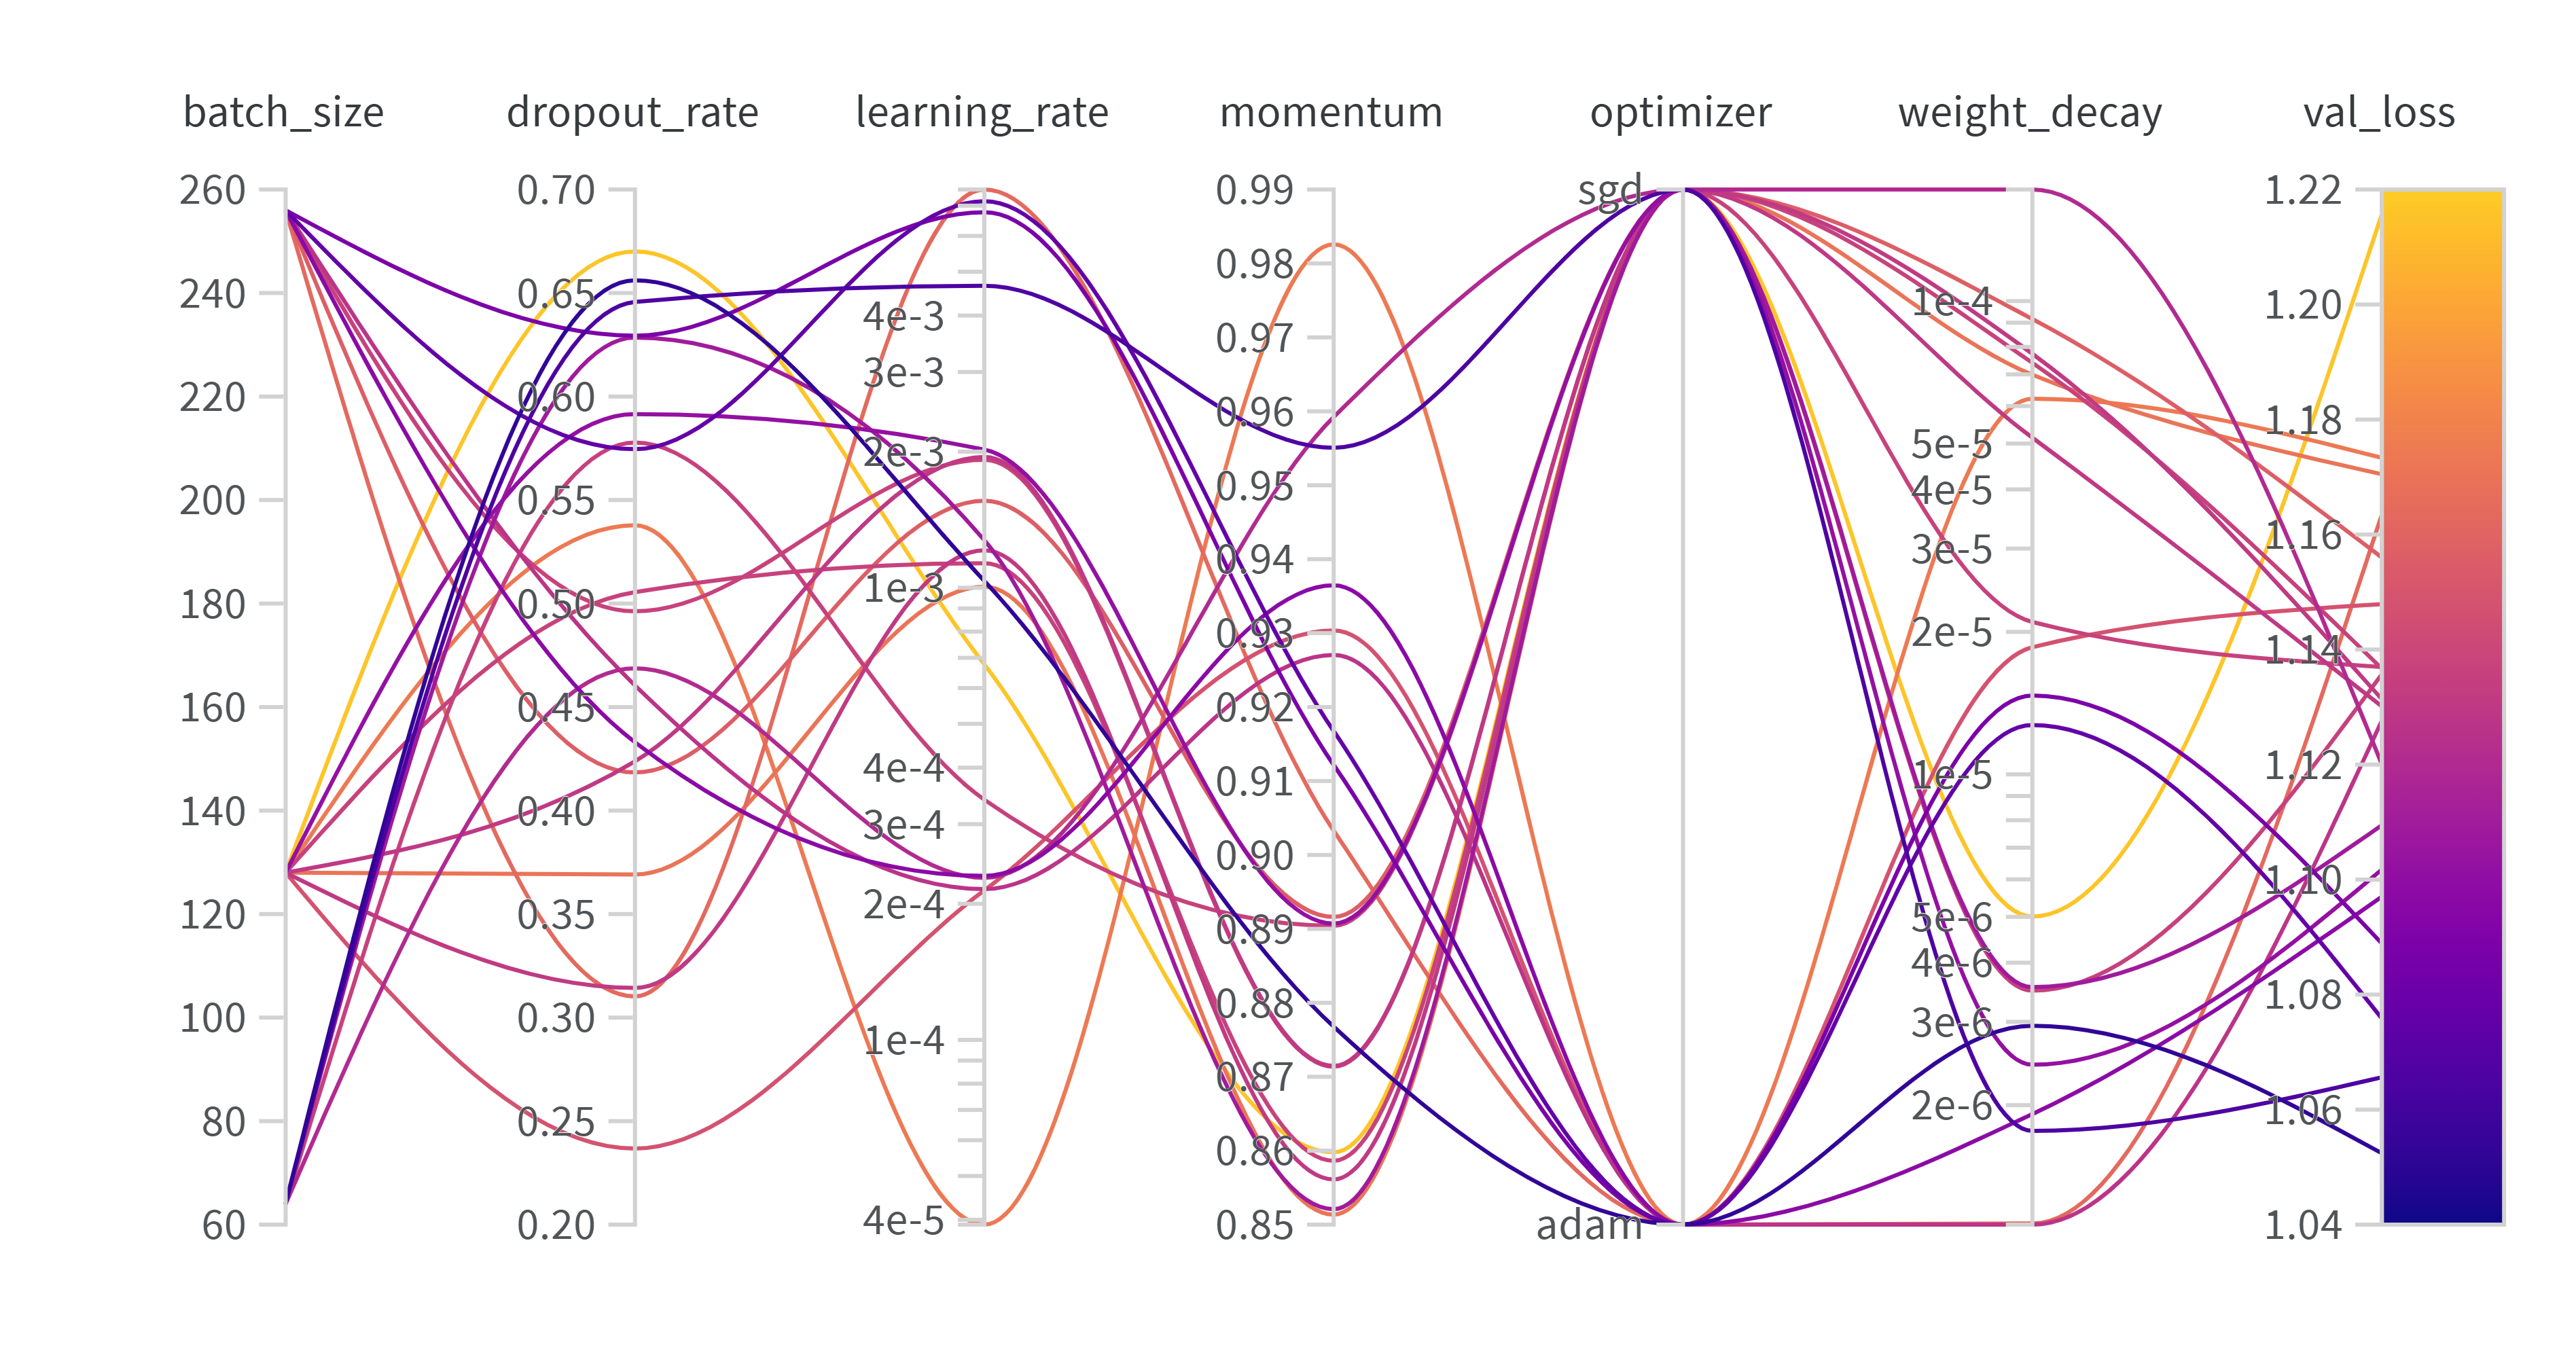

In [4]:
Image("wandb1.png")

En el gráfico observamos las distintas ejecuciones del sweep, con su configuración de hiperparámetros y la val loss obtenida.
A simple vista podemos observar como las configuraciones con mejores resultados parecen tener un mayor dropout rate. Esto también se puede observar en la siguiente visualización.

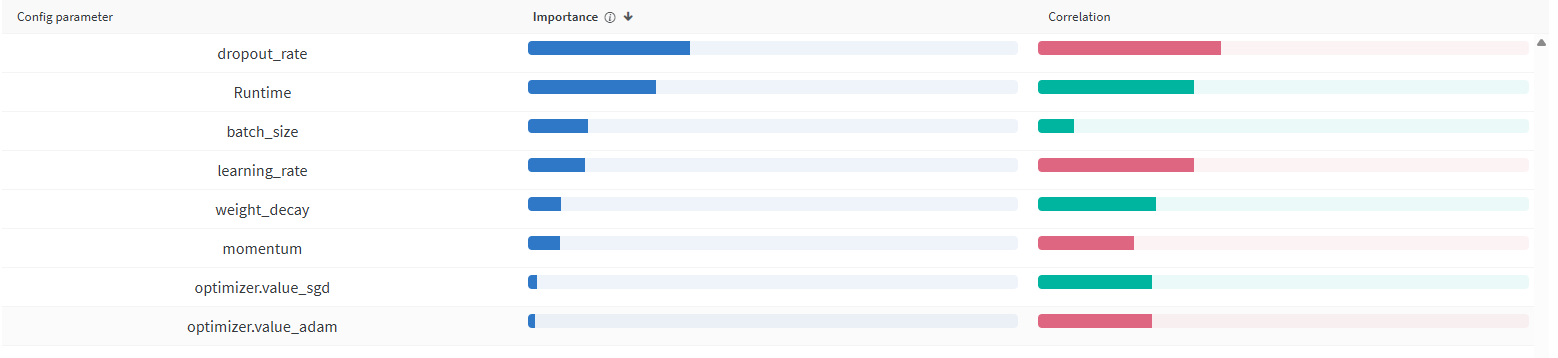

In [7]:
Image("wandb3.png")

Como mencionamos anteriormente el dropout_rate es el hiperparámetro que tuvo mayor importancia y mayor correlación (negativa en este caso ya que a mayor dropout rate menor fue la val loss) con la perdida en validación.

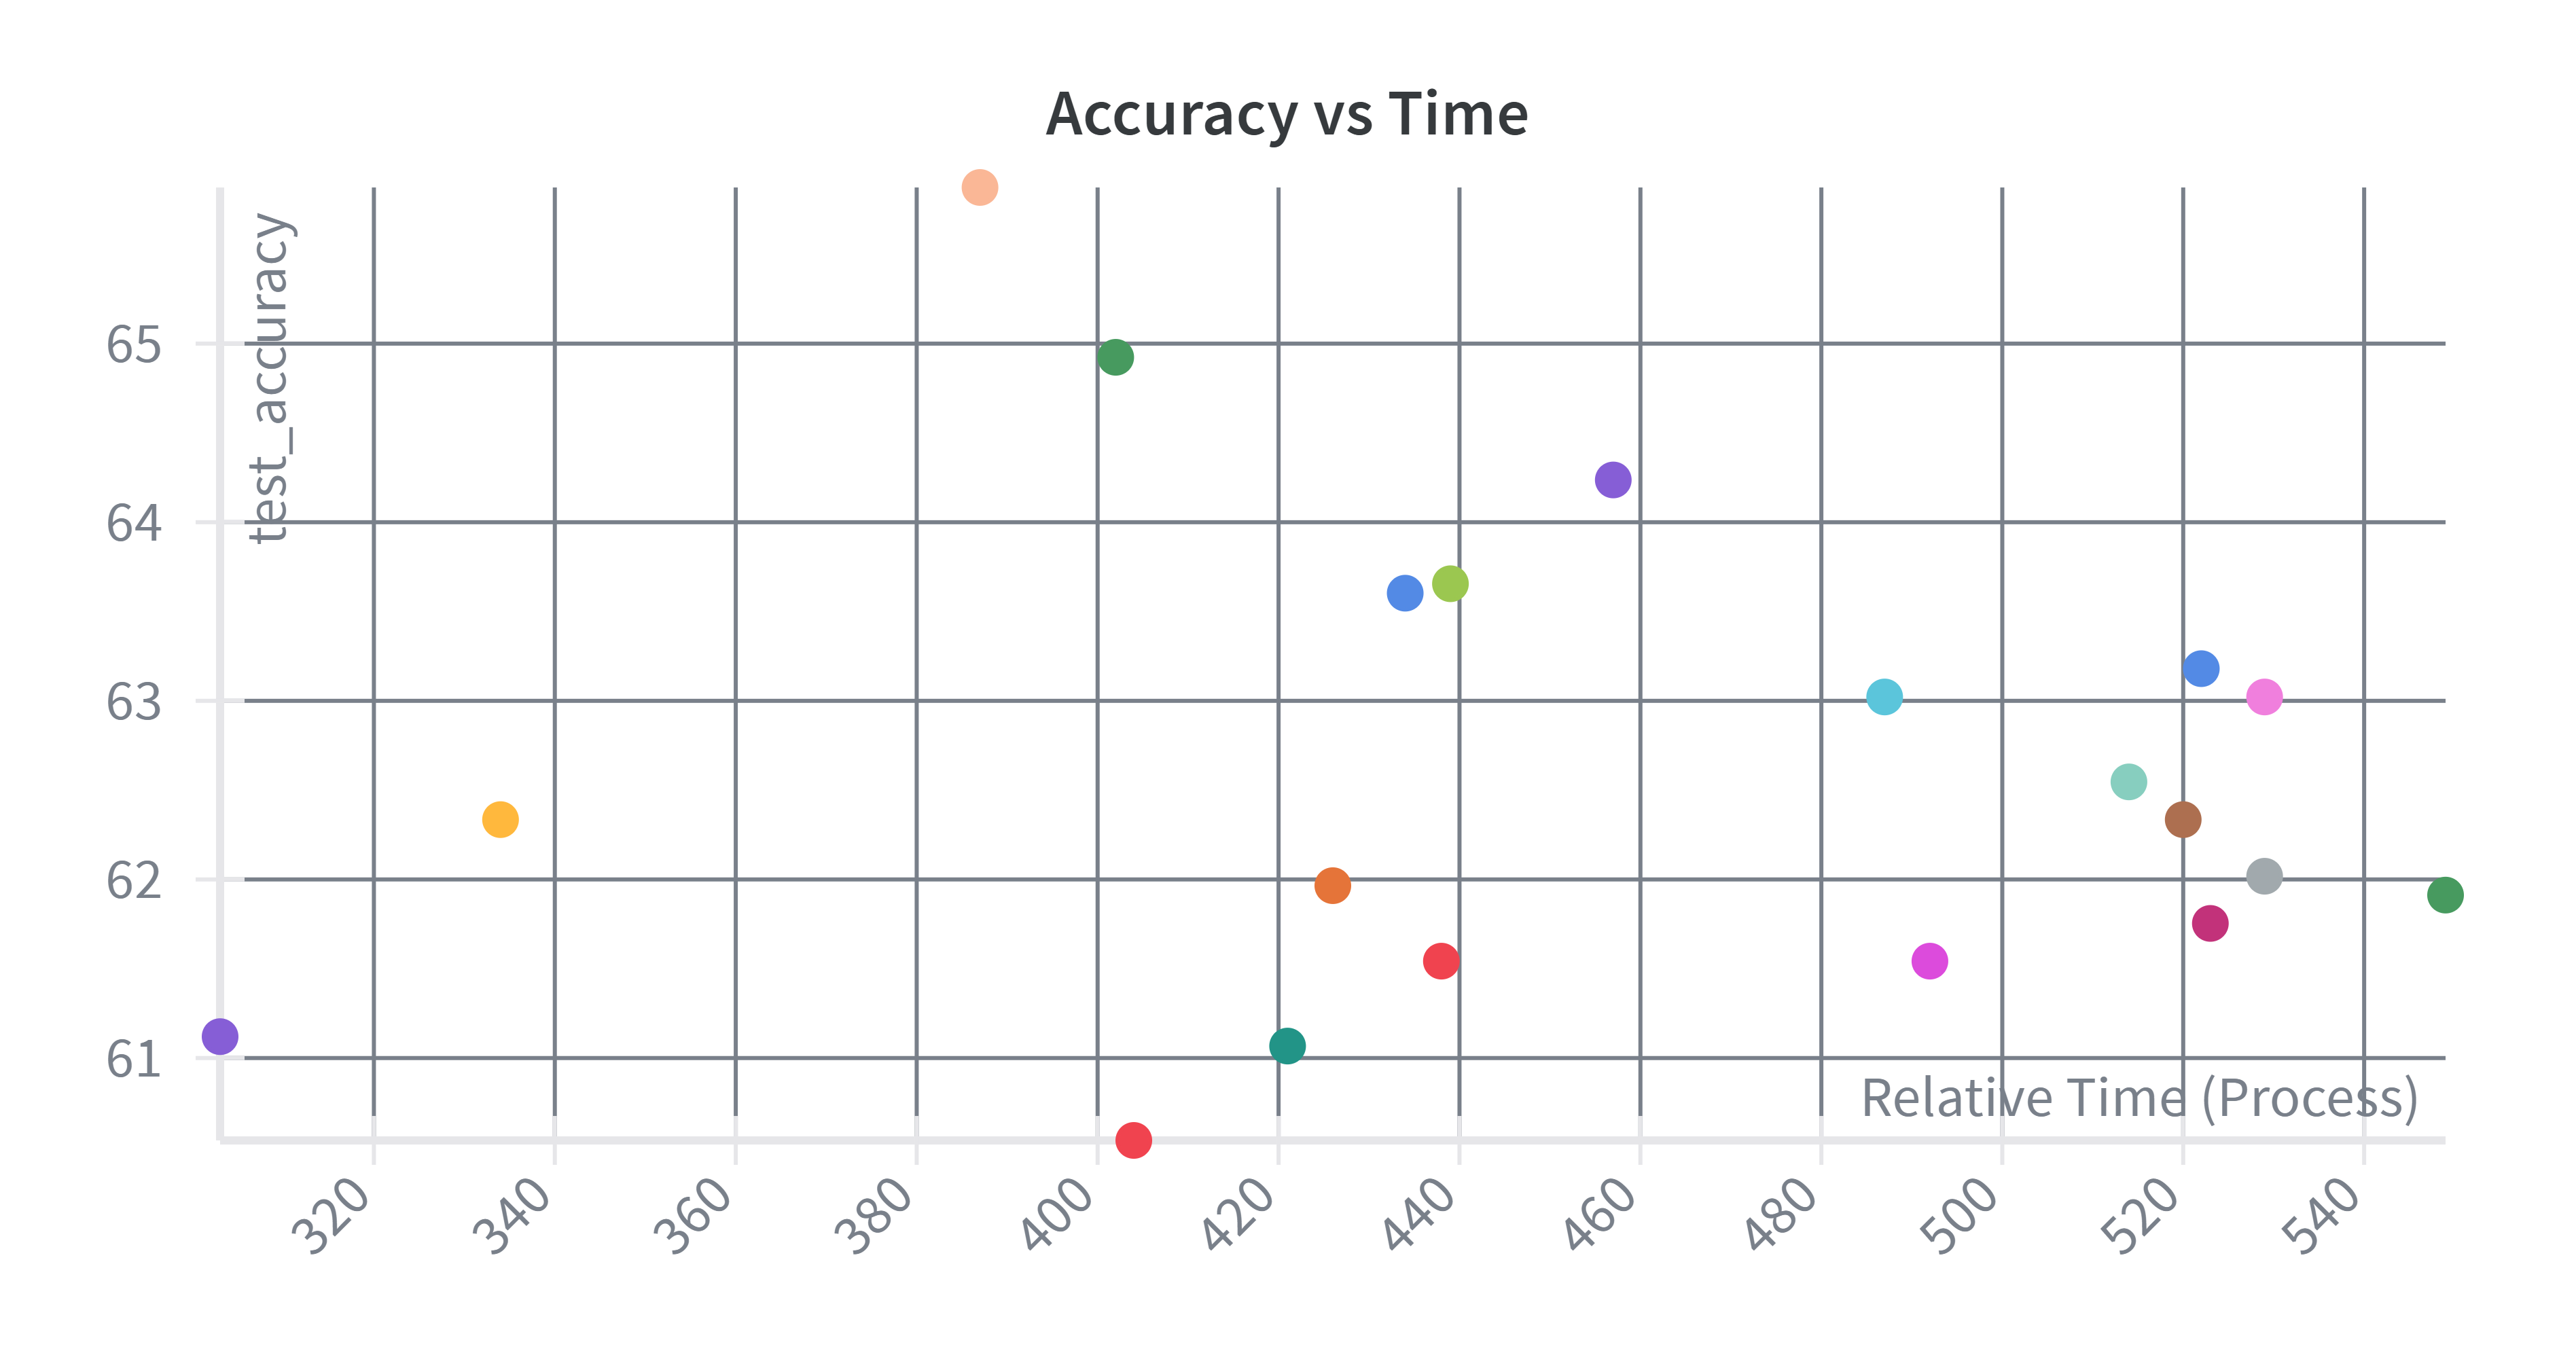

In [8]:
Image("wandb2.png")

Observamos en este grafico de accuracy en test vs runtime que las configuraciones que obtuvieron mejor accuracy en test no fueron de las que demoraron mas tiempo en entrenar